Importing all needed libraries

In [89]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import csv
import os
import shutil
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance


print (len(tf.config.experimental.list_physical_devices('GPU')))


1


read csv file and count number of each label that presented in our dataset then print out the result by showing them using plot

Label counts:
pepperoni: 2044
bacon: 187
mushrooms: 875
onions: 933
peppers: 816
black_olives: 851
tomatoes: 1822
spinach: 419
fresh_basil: 1289
arugula: 213
broccoli: 73
corn: 241
pineapple: 83


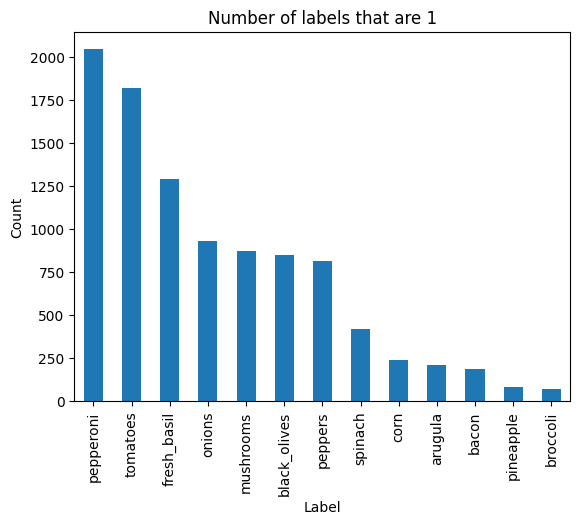

Rows with only one label being 1 for each label:
pepperoni: 1309
bacon: 72
mushrooms: 304
onions: 220
peppers: 145
black_olives: 211
tomatoes: 587
spinach: 190
fresh_basil: 751
arugula: 80
broccoli: 16
corn: 66
pineapple: 33


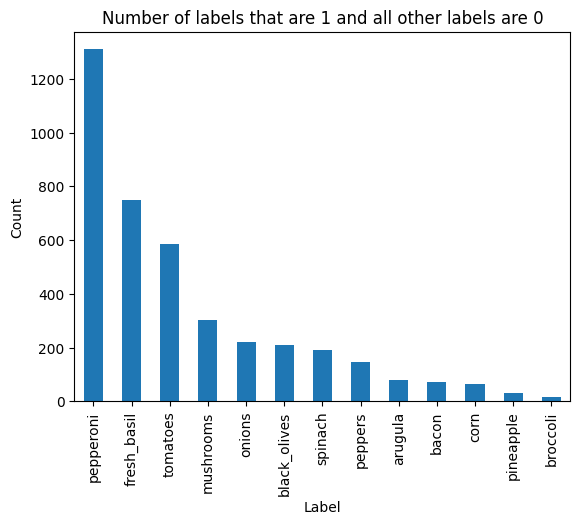

{'pepperoni': 1309, 'fresh_basil': 751, 'tomatoes': 587, 'mushrooms': 304, 'onions': 220, 'black_olives': 211, 'spinach': 190, 'peppers': 145, 'arugula': 80, 'bacon': 72, 'corn': 66, 'pineapple': 33, 'broccoli': 16}


In [12]:
# Define the CSV file path and the label names
csv_file_path = 'labels.csv'
label_names = ['pepperoni', 'bacon', 'mushrooms', 'onions', 'peppers', 'black_olives', 'tomatoes', 'spinach', 'fresh_basil', 'arugula', 'broccoli', 'corn', 'pineapple']

# Initialize a dictionary to count the occurrences of each label being 1
label_counts = {label: 0 for label in label_names}

# Initialize a dictionary to count the number of rows where only one label is 1 for each label
one_label_counts = {label: 0 for label in label_names}

# Open the CSV file and read the rows
with open(csv_file_path, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # skip the header row
    for row in reader:
        # Check how many labels are 1 in this row
        num_ones = 0
        last_index = -1
        for i, label in enumerate(row[1:]):
            if label == '1':
                num_ones += 1
                label_counts[label_names[i]] += 1
                last_index = i

        # Increment the one_label_counts if there is only one label that is 1
        if num_ones == 1:
            one_label_counts[label_names[last_index]] += 1
# Print the label counts and the count of rows where only one label being 1 for each label
print("Label counts:")
for label, count in label_counts.items():
    print(f'{label}: {count}')
label_counts = dict(sorted(label_counts.items(), key=lambda x: x[1], reverse=True))
pd.Series(label_counts).plot(kind='bar')
# Set the plot title and axis labels
plt.title('Number of labels that are 1')
plt.xlabel('Label')
plt.ylabel('Count')
# Display the plot
plt.show()

print("Rows with only one label being 1 for each label:")
for label, count in one_label_counts.items():
    print(f'{label}: {count}')


one_label_counts = dict(sorted(one_label_counts.items(), key=lambda x: x[1], reverse=True))
pd.Series(one_label_counts).plot(kind='bar')
# Set the plot title and axis labels
plt.title('Number of labels that are 1 and all other labels are 0')
plt.xlabel('Label')
plt.ylabel('Count')

# Display the plot
plt.show()


print(one_label_counts)

read csv file and create train and validation set. we split data randomly. 80% for training and 20% for validating. using datagen we normalized the input features by rescaling them to value between 0 to 1 (original rgb image has value between 0 and 255). finally we read images and labels using datagen.

In [86]:
#read csv file
df = pd.read_csv('labels.csv')
columns =  ['pepperoni', 'bacon', 'mushrooms', 'onions', 'peppers', 'black_olives', 'tomatoes', 'spinach', 'fresh_basil', 'arugula', 'broccoli', 'corn', 'pineapple']
# Create image generators for the training and testing sets
datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# Define the batch size
batch_size = 32
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(dataframe=train_df,
                                              directory="images",
                                              x_col='image_name',
                                              y_col=columns,
                                              seed=42,
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='raw')

# Create a generator for the testing data
valid_generator = datagen.flow_from_dataframe(dataframe=valid_df,
                                                  directory="images",
                                                  x_col='image_name',
                                                  y_col=columns,
                                                  seed=42,
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode='raw')

Found 7370 validated image filenames.
Found 1843 validated image filenames.


plotting our dataset using matplot library.

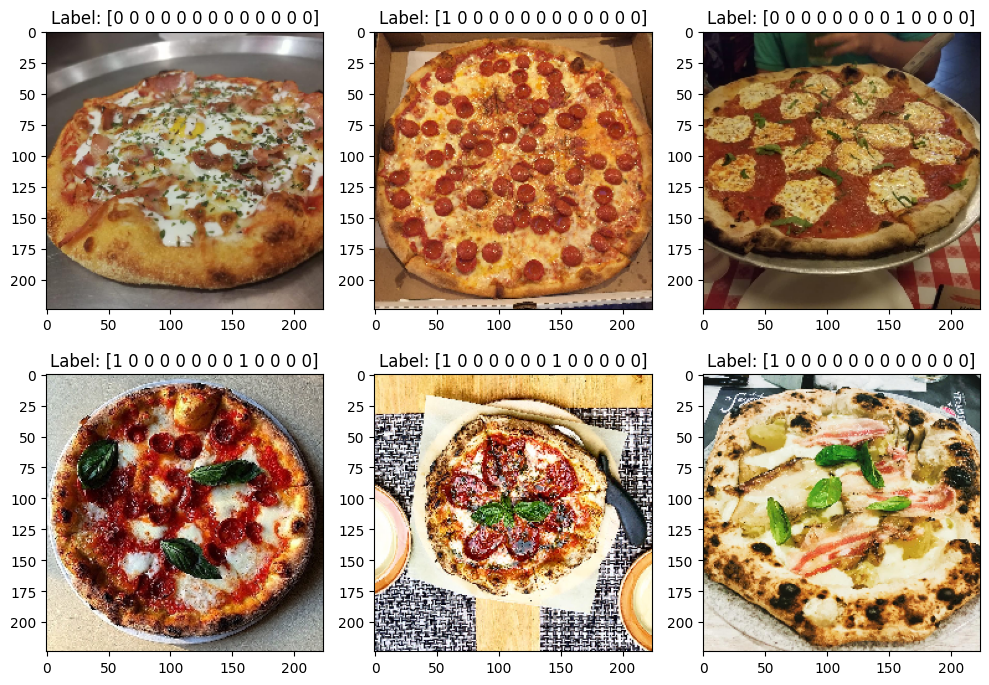

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
axs = axs.flatten()

for i in range(6):
    batch = train_generator.next()
    axs[i].imshow(batch[0][0])
    axs[i].set_title(f"Label: {batch[1][0]}")

plt.tight_layout()
plt.show()

Creating a neural network model with 3 cnn layer and 3 maxpool layers. we added a dense layer after flatten layer and for the output layer we used sigmoid function.

In [26]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(13, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


running model by passing train and valid data to it. we save all metrics to History.

In [27]:
History = model.fit(train_generator, epochs=10,
                    validation_data=valid_generator)

Epoch 1/10
231/231 [==============================] - 53s 226ms/step - loss: 0.3184 - accuracy: 0.2566 - val_loss: 0.2571 - val_accuracy: 0.4379
Epoch 2/10
231/231 [==============================] - 52s 225ms/step - loss: 0.2490 - accuracy: 0.3525 - val_loss: 0.2612 - val_accuracy: 0.2208
Epoch 3/10
231/231 [==============================] - 52s 223ms/step - loss: 0.2439 - accuracy: 0.3692 - val_loss: 0.2531 - val_accuracy: 0.3614
Epoch 4/10
231/231 [==============================] - 51s 222ms/step - loss: 0.2384 - accuracy: 0.3726 - val_loss: 0.2564 - val_accuracy: 0.3993
Epoch 5/10
231/231 [==============================] - 52s 224ms/step - loss: 0.2307 - accuracy: 0.3787 - val_loss: 0.2458 - val_accuracy: 0.3635
Epoch 6/10
231/231 [==============================] - 52s 226ms/step - loss: 0.2199 - accuracy: 0.3999 - val_loss: 0.2458 - val_accuracy: 0.3418
Epoch 7/10
231/231 [==============================] - 51s 222ms/step - loss: 0.2039 - accuracy: 0.4206 - val_loss: 0.2644 - val_ac

Plotting the history to see the curve of accuracy and loss for both training and validating the model.

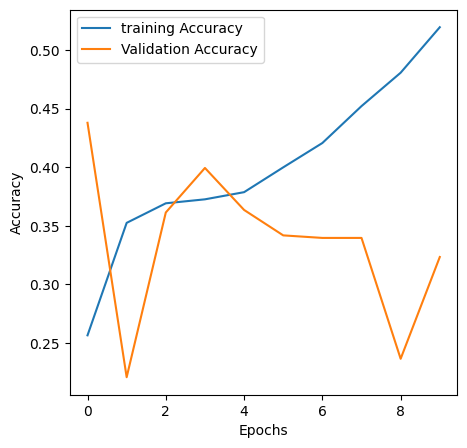

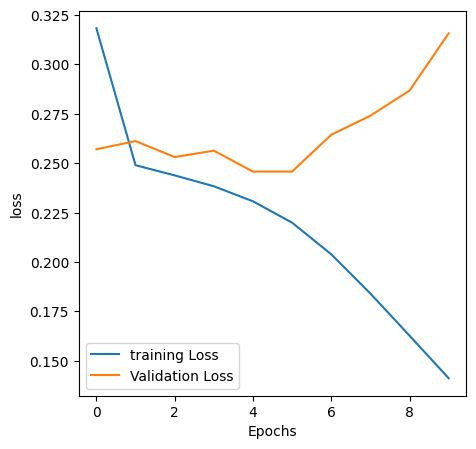

In [29]:
plt.figure(figsize=(5,5))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(History.history['accuracy'] , label='training Accuracy')
plt.plot(History.history['val_accuracy'] , label='Validation Accuracy')
plt.legend()
plt.figure(figsize=(5,5))
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.plot(History.history['loss'], label='training Loss')
plt.plot(History.history['val_loss'], label='Validation Loss')
plt.legend()


Now we select 4 most common label in the dataset.
Pepperoni , tomatoes , mushrooms and fresh-basil
we created a new dataframe and remove all data that contain other labels.
finally we save the dataframe to csv file.

In [13]:
count = 0
ImageToDelete = []
rows_to_delete = []
sample = ['pepperoni', 'bacon', 'mushrooms', 'onions', 'peppers', 'black_olives', 'tomatoes', 'spinach', 'fresh_basil', 'arugula', 'broccoli', 'corn', 'pineapple']
for index, row in df.iterrows():
    if  ((row['bacon'] == 0) & (row['pineapple'] == 0)  & (row['black_olives'] == 0)  & (row['spinach'] == 0)  & (row['arugula'] == 0) & (row['broccoli'] == 0) & (row['onions'] == 0) & (row['corn'] == 0)  & (row['peppers'] == 0) ) & ((row['pepperoni'] == 1) or (row['tomatoes'] == 1) or (row['fresh_basil'] == 1) or  (row['mushrooms'] == 1)):

    # Case 1: Only pepperoni is 1
        count = count + 1
    else:
        ImageToDelete.append(row['image_name'])
        rows_to_delete.append(index)
fourcommondf = df.drop(rows_to_delete)
        # rows_to_delete.append(index)
print(count , "Rows found")
fourcommondf =fourcommondf.drop([ 'bacon',  'onions', 'black_olives',  'spinach', 'peppers', 'arugula', 'broccoli', 'corn', 'pineapple'], axis=1)
fourcommondf.shape

3554 Rows found


(3554, 5)

Coping all images from source folder to a new folder name 'fourcommon'.
we have done it because we want to remove images that not presented in the new csv file.

In [8]:
source_dir = 'images'
dest_dir = 'fourcommon'
for filename in os.listdir(source_dir):
    shutil.copy(os.path.join(source_dir, filename), os.path.join(dest_dir, filename))


removing all images that are not presented in the new dataframe.

In [9]:
fourcommonImagePath = 'fourcommon'
print(fourcommonImagePath)
for file_name in ImageToDelete:
        file_path = os.path.join(fourcommonImagePath, file_name)
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"File {file_name} deleted successfully")
fourcommondf.to_csv('fourcommon.csv', index=False)


0
fourcommon
File 00001.jpg deleted successfully
File 00004.jpg deleted successfully
File 00009.jpg deleted successfully
File 00011.jpg deleted successfully
File 00013.jpg deleted successfully
File 00014.jpg deleted successfully
File 00015.jpg deleted successfully
File 00017.jpg deleted successfully
File 00018.jpg deleted successfully
File 00019.jpg deleted successfully
File 00023.jpg deleted successfully
File 00024.jpg deleted successfully
File 00025.jpg deleted successfully
File 00028.jpg deleted successfully
File 00031.jpg deleted successfully
File 00032.jpg deleted successfully
File 00034.jpg deleted successfully
File 00038.jpg deleted successfully
File 00042.jpg deleted successfully
File 00043.jpg deleted successfully
File 00046.jpg deleted successfully
File 00047.jpg deleted successfully
File 00048.jpg deleted successfully
File 00049.jpg deleted successfully
File 00052.jpg deleted successfully
File 00053.jpg deleted successfully
File 00055.jpg deleted successfully
File 00056.jpg 

read fourcommon csv file and count number of each label that presented in fourcommon then print out the result by showing them using plot

Label counts:
pepperoni: 1599
mushrooms: 498
tomatoes: 989
fresh_basil: 1100


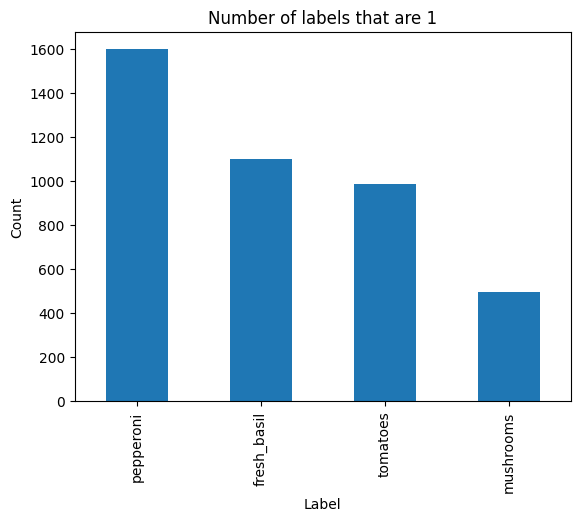

Rows with only one label being 1 for each label:
pepperoni: 1309
mushrooms: 304
tomatoes: 587
fresh_basil: 751


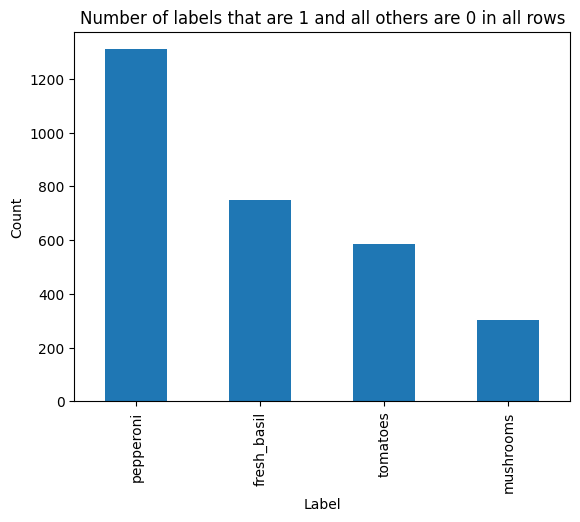

{'pepperoni': 1309, 'fresh_basil': 751, 'tomatoes': 587, 'mushrooms': 304}


In [24]:
# Define the CSV file path and the label names
csv_file_path = 'fourcommon.csv'
label_names = ['pepperoni', 'mushrooms', 'tomatoes', 'fresh_basil']

# Initialize a dictionary to count the occurrences of each label being 1
label_counts = {label: 0 for label in label_names}

# Initialize a dictionary to count the number of rows where only one label is 1 for each label
one_label_counts = {label: 0 for label in label_names}

# Open the CSV file and read the rows
with open(csv_file_path, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # skip the header row
    for row in reader:
        # Check how many labels are 1 in this row
        num_ones = 0
        last_index = -1
        for i, label in enumerate(row[1:]):
            if label == '1':
                num_ones += 1
                label_counts[label_names[i]] += 1
                last_index = i

        # Increment the one_label_counts if there is only one label that is 1
        if num_ones == 1:
            one_label_counts[label_names[last_index]] += 1
# Print the label counts and the count of rows where only one label being 1 for each label
print("Label counts:")
for label, count in label_counts.items():
    print(f'{label}: {count}')
label_counts = dict(sorted(label_counts.items(), key=lambda x: x[1], reverse=True))
pd.Series(label_counts).plot(kind='bar')
# Set the plot title and axis labels
plt.title('Number of labels that are 1')
plt.xlabel('Label')
plt.ylabel('Count')
# Display the plot
plt.show()

print("Rows with only one label being 1 for each label:")
for label, count in one_label_counts.items():
    print(f'{label}: {count}')


one_label_counts = dict(sorted(one_label_counts.items(), key=lambda x: x[1], reverse=True))
pd.Series(one_label_counts).plot(kind='bar')
# Set the plot title and axis labels
plt.title('Number of labels that are 1 and all others are 0 in all rows')
plt.xlabel('Label')
plt.ylabel('Count')

# Display the plot
plt.show()


print(one_label_counts)

according to the above chart, the number of sample in mushroom and tomatoes and fresh-basil are lower than peproni so we have to increase the number of sample to balance the database.

read csv file and create train and validation set. we split data randomly. 80% for training and 20% for validating. using datagen we normalized the input features by rescaling them to value between 0 and 1 (original rgb image has value between 0 and 255). finally we read images and labels using datagen.


In [30]:
# Create image generators for the training and testing sets
datagen = ImageDataGenerator(rescale=1./255)
fourcommondf = pd.read_csv('fourcommon.csv')
columns = ['pepperoni', 'mushrooms','tomatoes','fresh_basil']
# Define the batch size
batch_size = 32
train_df, valid_df = train_test_split(fourcommondf, test_size=0.2, random_state=42)
# Create a generator for the training data
train_generator_fourcommon = datagen.flow_from_dataframe(dataframe=train_df,
                                              directory="fourcommon",
                                              x_col='image_name',
                                              y_col=columns,
                                              seed=42,
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='raw')

# Create a generator for the testing data
valid_generator_fourcommon = datagen.flow_from_dataframe(dataframe=valid_df,
                                                  directory="fourcommon",
                                                  x_col='image_name',
                                                  y_col=columns,
                                                  seed=42,
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode='raw')

Found 2843 validated image filenames.
Found 711 validated image filenames.


plotting our new fourcommon dataset using matplot library.

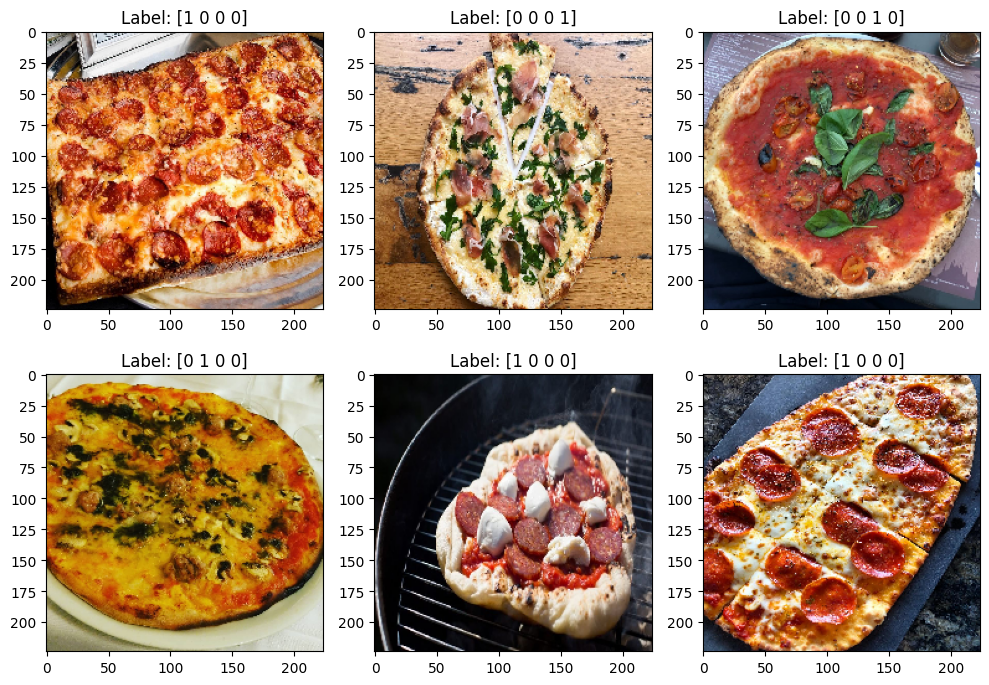

In [31]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
axs = axs.flatten()

for i in range(6):
    batch = train_generator_fourcommon.next()
    axs[i].imshow(batch[0][0])
    axs[i].set_title(f"Label: {batch[1][0]}")

plt.tight_layout()
plt.show()

Creating a neural network model with 3 cnn layer and 3 maxpool layers. we added a dense layer after flatten layer and for the output layer we used sigmoid function.

In [33]:
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(4, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [34]:
FCHistory1 = model.fit(train_generator_fourcommon, epochs=10,
                    validation_data=valid_generator_fourcommon)

Epoch 1/10
89/89 [==============================] - 22s 240ms/step - loss: 0.6019 - accuracy: 0.2346 - val_loss: 0.5703 - val_accuracy: 0.4557
Epoch 2/10
89/89 [==============================] - 20s 228ms/step - loss: 0.5707 - accuracy: 0.4351 - val_loss: 0.5381 - val_accuracy: 0.4740
Epoch 3/10
89/89 [==============================] - 20s 229ms/step - loss: 0.5425 - accuracy: 0.4900 - val_loss: 0.5218 - val_accuracy: 0.5120
Epoch 4/10
89/89 [==============================] - 21s 231ms/step - loss: 0.5140 - accuracy: 0.5248 - val_loss: 0.5118 - val_accuracy: 0.5218
Epoch 5/10
89/89 [==============================] - 20s 227ms/step - loss: 0.4653 - accuracy: 0.5955 - val_loss: 0.4732 - val_accuracy: 0.5992
Epoch 6/10
89/89 [==============================] - 20s 228ms/step - loss: 0.3752 - accuracy: 0.7007 - val_loss: 0.4684 - val_accuracy: 0.5865
Epoch 7/10
89/89 [==============================] - 20s 227ms/step - loss: 0.2921 - accuracy: 0.7619 - val_loss: 0.4793 - val_accuracy: 0.5977

Plotting the history to see the curve of accuracy and loss for both training and validating the model.

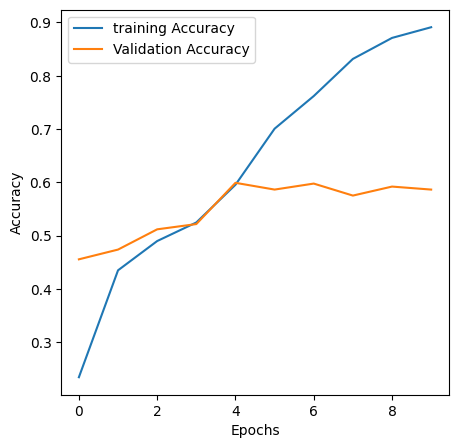

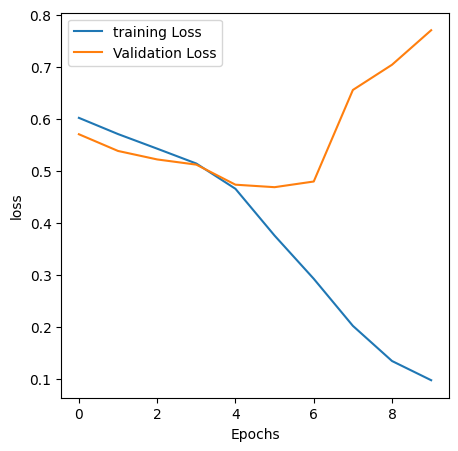

In [35]:
plt.figure(figsize=(5,5))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(FCHistory1.history['accuracy'] , label='training Accuracy')
plt.plot(FCHistory1.history['val_accuracy'] , label='Validation Accuracy')
plt.legend()
plt.figure(figsize=(5,5))
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.plot(FCHistory1.history['loss'], label='training Loss')
plt.plot(FCHistory1.history['val_loss'], label='Validation Loss')
plt.legend()


augmenting data: in order to augment the data we used height shift and width shift and zoom and rotate. we didn't augment data that have label of peperoni = 1 because the dataset is not balance and there are more data related to the peperoni . after augmenting each image, we save it to the same folder and add a row in the dataframe with the name of that image and the labels for it. after finishing data augmentation, we saved our dataframe to a csv file.

In [10]:
#augmentation
import warnings
warnings.filterwarnings("ignore")
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest')
from PIL import Image

new_df = pd.DataFrame(columns=['image_name', 'pepperoni', 'mushrooms', 'fresh_basil','tomatoes'])

# define the output folder for the augmented images
output_folder = 'newimages'
Image_base_path = 'images/'

count = 0
for index, row in fourcommondf.iterrows():
    # load the image from file
 if row['pepperoni']==0:
    img = Image.open(Image_base_path+row['image_name'])
    # augment the image
    img_array = np.array(img)
    img_array = img_array.reshape((1,) + img_array.shape)
    aug_iter = datagen.flow(img_array, batch_size=1)
    augmented_img_array = aug_iter.next()[0].astype(np.uint8)
    augmented_img = Image.fromarray(augmented_img_array)
    # save the augmented image to file
    filename = os.path.basename(row['image_name'])
    augmented_img = augmented_img.convert('RGB')
    augmented_img.save('fourcommon' + '/' + 'aug_' +filename)
    count = count+1
    print(count , 'new file Created', end='\r')

    # add the augmented image filename and label to the new dataframe
    new_row = {'image_name': 'aug_' + filename, 'pepperoni' : row['pepperoni'], 'mushrooms': row['mushrooms'], 'fresh_basil': row['fresh_basil'],'tomatoes': row['tomatoes']}
    new_df = new_df.append(new_row, ignore_index=True)
# # save the new dataframe to CSV
fourcommondf_aug = pd.concat([fourcommondf, new_df], axis=0)
fourcommondf_aug.to_csv('fourcommondf_aug.csv', index=False)

(1955, 5)file Created


augmenting mushrooms because we want to make our dataset balance.

In [19]:
#augmentation
import warnings
warnings.filterwarnings("ignore")
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest')
from PIL import Image

new_df = pd.DataFrame(columns=['image_name', 'pepperoni', 'mushrooms', 'fresh_basil','tomatoes'])

# define the output folder for the augmented images
Image_base_path = 'fourcommon/'

count = 0
for index, row in fourcommondf_aug.iterrows():
    # load the image from file
 if row['pepperoni']==0 and row['mushrooms']==1:
    img = Image.open(Image_base_path+row['image_name'])
    # augment the image
    img_array = np.array(img)
    img_array = img_array.reshape((1,) + img_array.shape)
    aug_iter = datagen.flow(img_array, batch_size=1)
    augmented_img_array = aug_iter.next()[0].astype(np.uint8)
    augmented_img = Image.fromarray(augmented_img_array)
    # save the augmented image to file
    filename = os.path.basename(row['image_name'])
    augmented_img = augmented_img.convert('RGB')
    augmented_img.save('fourcommon' + '/' + 'aug_m' +filename)
    count = count+1
    print(count , 'new file Created', end='\r')

    # add the augmented image filename and label to the new dataframe
    new_row = {'image_name': 'aug_m' + filename, 'pepperoni' : row['pepperoni'], 'mushrooms': row['mushrooms'], 'fresh_basil': row['fresh_basil'],'tomatoes': row['tomatoes']}
    new_df = new_df.append(new_row, ignore_index=True)


# # save the new dataframe to CSV
fourcommondf_aug = pd.concat([fourcommondf_aug, new_df], axis=0)
fourcommondf_aug.to_csv('fourcommondf_aug.csv', index=False)

read csv file and count number of each label that presented in our new dataset then print out the result by showing them using plot

Label counts:
pepperoni: 1599
mushrooms: 1692
tomatoes: 2008
fresh_basil: 2172


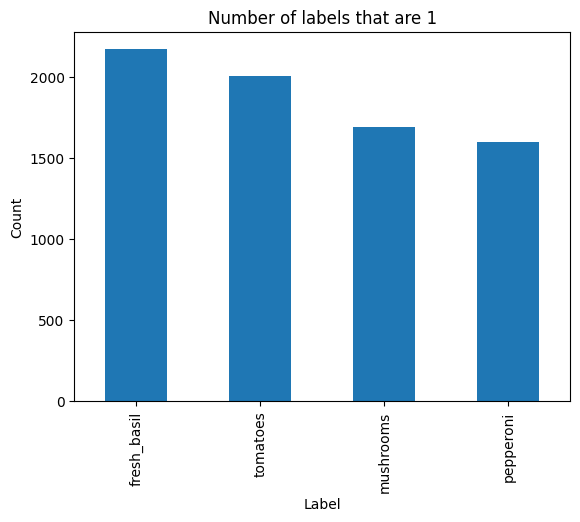

Rows with only one label being 1 for each label:
pepperoni: 1309
mushrooms: 1216
tomatoes: 1174
fresh_basil: 1502


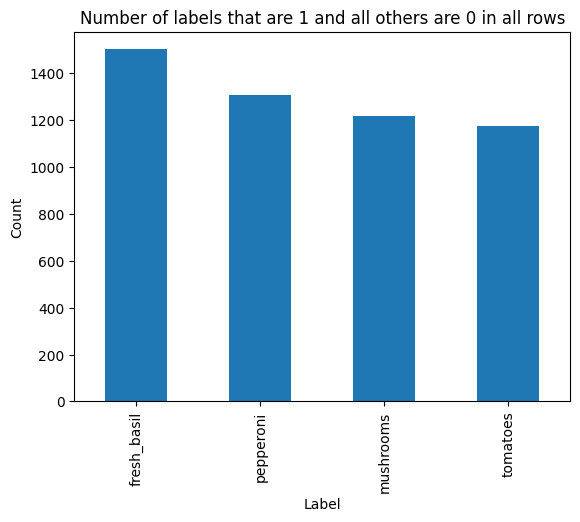

{'fresh_basil': 1502, 'pepperoni': 1309, 'mushrooms': 1216, 'tomatoes': 1174}


In [36]:
# Define the CSV file path and the label names
csv_file_path = 'fourcommondf_aug.csv'
label_names = ['pepperoni', 'mushrooms', 'tomatoes', 'fresh_basil']

# Initialize a dictionary to count the occurrences of each label being 1
label_counts = {label: 0 for label in label_names}

# Initialize a dictionary to count the number of rows where only one label is 1 for each label
one_label_counts = {label: 0 for label in label_names}

# Open the CSV file and read the rows
with open(csv_file_path, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # skip the header row
    for row in reader:
        # Check how many labels are 1 in this row
        num_ones = 0
        last_index = -1
        for i, label in enumerate(row[1:]):
            if label == '1':
                num_ones += 1
                label_counts[label_names[i]] += 1
                last_index = i

        # Increment the one_label_counts if there is only one label that is 1
        if num_ones == 1:
            one_label_counts[label_names[last_index]] += 1
# Print the label counts and the count of rows where only one label being 1 for each label
print("Label counts:")
for label, count in label_counts.items():
    print(f'{label}: {count}')
label_counts = dict(sorted(label_counts.items(), key=lambda x: x[1], reverse=True))
pd.Series(label_counts).plot(kind='bar')
# Set the plot title and axis labels
plt.title('Number of labels that are 1')
plt.xlabel('Label')
plt.ylabel('Count')
# Display the plot
plt.show()

print("Rows with only one label being 1 for each label:")
for label, count in one_label_counts.items():
    print(f'{label}: {count}')


one_label_counts = dict(sorted(one_label_counts.items(), key=lambda x: x[1], reverse=True))
pd.Series(one_label_counts).plot(kind='bar')
# Set the plot title and axis labels
plt.title('Number of labels that are 1 and all others are 0 in all rows')
plt.xlabel('Label')
plt.ylabel('Count')

# Display the plot
plt.show()


print(one_label_counts)

read csv file and create train and validation set. we split data randomly. 80% for training and 20% for validating. using datagen we normalized the input features by rescaling them to value between 0 to 1 (original rgb image has value between 0 and 255). finally we read images and labels using datagen.


In [37]:
# Create image generators for the training and testing sets
datagen = ImageDataGenerator(rescale=1./255)
fourcommondf_aug = pd.read_csv('fourcommondf_aug.csv')
columns = ['pepperoni', 'mushrooms','tomatoes','fresh_basil']
# Define the batch size
batch_size = 32
train_df, valid_df = train_test_split(fourcommondf_aug, test_size=0.2, random_state=42)
# Create a generator for the training data
train_generator_fourcommon_aug = datagen.flow_from_dataframe(dataframe=train_df,
                                              directory="fourcommon",
                                              x_col='image_name',
                                              y_col=columns,
                                              seed=42,
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='raw')

# Create a generator for the testing data
valid_generator_fourcommon_aug = datagen.flow_from_dataframe(dataframe=valid_df,
                                                  directory="fourcommon",
                                                  x_col='image_name',
                                                  y_col=columns,
                                                  seed=42,
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode='raw')


Found 5044 validated image filenames.
Found 1261 validated image filenames.


Creating a neural network model with 3 cnn layer and 3 maxpool layers. we added a dense layer after flatten layer and for the output layer we used sigmoid function.

In [38]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(4, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
FCHistory2 = model.fit(train_generator_fourcommon_aug, epochs=10,
                    validation_data=valid_generator_fourcommon_aug)

Epoch 1/10
158/158 [==============================] - 38s 237ms/step - loss: 0.6639 - accuracy: 0.2385 - val_loss: 0.6241 - val_accuracy: 0.2387
Epoch 2/10
158/158 [==============================] - 33s 206ms/step - loss: 0.6032 - accuracy: 0.2799 - val_loss: 0.5823 - val_accuracy: 0.2910
Epoch 3/10
158/158 [==============================] - 32s 201ms/step - loss: 0.5684 - accuracy: 0.3644 - val_loss: 0.5448 - val_accuracy: 0.4036
Epoch 4/10
158/158 [==============================] - 32s 204ms/step - loss: 0.5363 - accuracy: 0.4225 - val_loss: 0.5392 - val_accuracy: 0.4195
Epoch 5/10
158/158 [==============================] - 32s 202ms/step - loss: 0.5127 - accuracy: 0.4780 - val_loss: 0.5234 - val_accuracy: 0.5258
Epoch 6/10
158/158 [==============================] - 32s 204ms/step - loss: 0.4859 - accuracy: 0.5337 - val_loss: 0.5067 - val_accuracy: 0.5170
Epoch 7/10
158/158 [==============================] - 32s 200ms/step - loss: 0.4276 - accuracy: 0.5916 - val_loss: 0.4608 - val_ac

Plotting the history to see the curve of accuracy and loss for both training and validating the model.

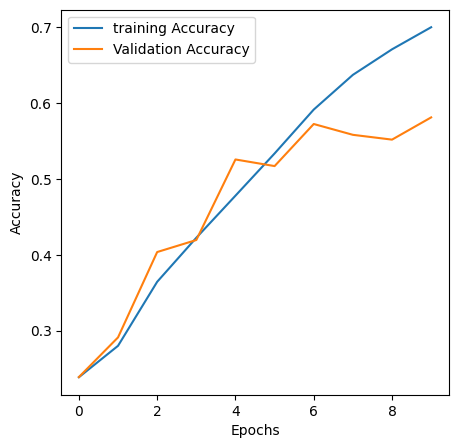

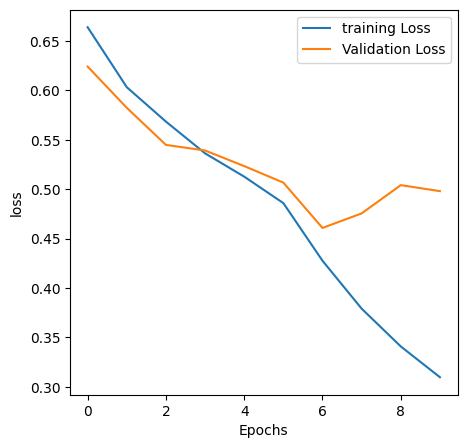

In [39]:
plt.figure(figsize=(5,5))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(FCHistory2.history['accuracy'] , label='training Accuracy')
plt.plot(FCHistory2.history['val_accuracy'] , label='Validation Accuracy')
plt.legend()
plt.figure(figsize=(5,5))
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.plot(FCHistory2.history['loss'], label='training Loss')
plt.plot(FCHistory2.history['val_loss'], label='Validation Loss')
plt.legend()

, we used computer vision techniques to enhance the contrast and brightness of the images in our dataset to help the model train better. This technique can be useful in situations where the images in the dataset are of varying quality, and some may be too dark or too light. By increasing the contrast and brightness of the images, the details in the images become more visible, which can help the model make better predictions.
We used the Pillow library to perform the contrast and brightness enhancement
. We iterated through all the images in our dataset, increased their contrast and brightness, and saved the edited images in a new folder named "high".

In [88]:
input_folder = 'fourcommon'
output_folder = 'high'
factor = 2
batch_size = 32

# Loop through all image files in the input folder in batches
filenames = [filename for filename in os.listdir(input_folder) if filename.endswith('.jpg') or filename.endswith('.png')]
for i in range(0, len(filenames), batch_size):
    batch_filenames = filenames[i:i+batch_size]

    # Process the batch of images
    for filename in batch_filenames:
        # Open the image
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path)

        # Enhance the green channel
        color = ImageEnhance.Contrast(img)
        new_img = color.enhance(factor)

        # Save the result to the output folder
        output_path = os.path.join(output_folder, filename)
        new_img = new_img.convert('RGB')
        new_img.save(output_path)


In [40]:
# Create image generators for the training and testing sets
datagen = ImageDataGenerator(rescale=1./255)
fourcommondf_aug = pd.read_csv('fourcommondf_aug.csv')
columns = ['pepperoni', 'mushrooms','tomatoes','fresh_basil']
# Define the batch size
batch_size = 32
train_df, valid_df = train_test_split(fourcommondf_aug, test_size=0.2, random_state=42)
# Create a generator for the training data
train_generator_fourcommon_aug = datagen.flow_from_dataframe(dataframe=train_df,
                                              directory="high",
                                              x_col='image_name',
                                              y_col=columns,
                                              seed=42,
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='raw')

# Create a generator for the testing data
valid_generator_fourcommon_aug = datagen.flow_from_dataframe(dataframe=valid_df,
                                                  directory="high",
                                                  x_col='image_name',
                                                  y_col=columns,
                                                  seed=42,
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode='raw')



Found 5044 validated image filenames.
Found 1261 validated image filenames.


Creating a neural network model with 3 cnn layer and 3 maxpool layers. we added a dense layer after flatten layer and for the output layer we used sigmoid function.

In [42]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(4, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


running model by passing train and valid data to it. we save all metrics to FCHistory3.

In [43]:
FCHistory3 = model.fit(train_generator_fourcommon_aug, epochs=10,
                    validation_data=valid_generator_fourcommon_aug)

Epoch 1/10
158/158 [==============================] - 35s 218ms/step - loss: 0.6197 - accuracy: 0.3297 - val_loss: 0.5747 - val_accuracy: 0.3949
Epoch 2/10
158/158 [==============================] - 28s 178ms/step - loss: 0.5654 - accuracy: 0.3959 - val_loss: 0.5405 - val_accuracy: 0.4274
Epoch 3/10
158/158 [==============================] - 28s 175ms/step - loss: 0.5256 - accuracy: 0.4316 - val_loss: 0.5166 - val_accuracy: 0.4504
Epoch 4/10
158/158 [==============================] - 28s 176ms/step - loss: 0.4771 - accuracy: 0.5373 - val_loss: 0.5017 - val_accuracy: 0.5353
Epoch 5/10
158/158 [==============================] - 30s 187ms/step - loss: 0.4130 - accuracy: 0.6243 - val_loss: 0.5332 - val_accuracy: 0.5480
Epoch 6/10
158/158 [==============================] - 29s 181ms/step - loss: 0.3322 - accuracy: 0.7074 - val_loss: 0.5277 - val_accuracy: 0.5448
Epoch 7/10
158/158 [==============================] - 29s 183ms/step - loss: 0.2478 - accuracy: 0.7801 - val_loss: 0.6217 - val_ac

Plotting the history to see the curve of accuracy and loss for both training and validating the model.

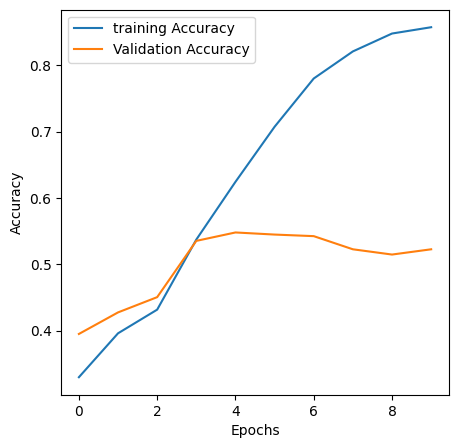

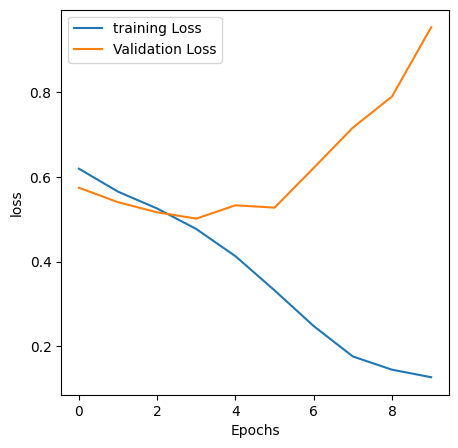

In [44]:
plt.figure(figsize=(5,5))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(FCHistory3.history['accuracy'] , label='training Accuracy')
plt.plot(FCHistory3.history['val_accuracy'] , label='Validation Accuracy')
plt.legend()
plt.figure(figsize=(5,5))
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.plot(FCHistory3.history['loss'], label='training Loss')
plt.plot(FCHistory3.history['val_loss'], label='Validation Loss')
plt.legend()

Creating new dataframe than contains rows with labels of peperoni mushrooms and fresh-basil and tomatoes = 0

In [78]:
count = 0
ImageToDelete = []
rows_to_delete = []
for index, row in fourcommondf_aug.iterrows():
    if  (row['tomatoes'] == 0):
        count = count + 1
    else:
        ImageToDelete.append(row['image_name'])
        rows_to_delete.append(index)
threecommon = fourcommondf_aug.drop(rows_to_delete)
        # rows_to_delete.append(index)
print(count , "Rows found")
threecommon =threecommon.drop(['tomatoes'], axis=1)
threecommon.to_csv('threecommon.csv', index=False)

4297 Rows found


Copping all data from high folder to threecommon

In [79]:
source_dir = 'high'
dest_dir = 'threecommon'
for filename in os.listdir(source_dir):
    shutil.copy(os.path.join(source_dir, filename), os.path.join(dest_dir, filename))

removing all images that are not presented in the new dataframe.

In [81]:
ImagePath = 'threecommon'
for file_name in ImageToDelete:
        file_path = os.path.join(ImagePath, file_name)
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"File {file_name} deleted successfully")


File 00010.jpg deleted successfully
File 00027.jpg deleted successfully
File 00029.jpg deleted successfully
File 00030.jpg deleted successfully
File 00033.jpg deleted successfully
File 00036.jpg deleted successfully
File 00040.jpg deleted successfully
File 00057.jpg deleted successfully
File 00062.jpg deleted successfully
File 00066.jpg deleted successfully
File 00071.jpg deleted successfully
File 00076.jpg deleted successfully
File 00083.jpg deleted successfully
File 00100.jpg deleted successfully
File 00106.jpg deleted successfully
File 00111.jpg deleted successfully
File 00131.jpg deleted successfully
File 00137.jpg deleted successfully
File 00147.jpg deleted successfully
File 00152.jpg deleted successfully
File 00160.jpg deleted successfully
File 00162.jpg deleted successfully
File 00179.jpg deleted successfully
File 00180.jpg deleted successfully
File 00183.jpg deleted successfully
File 00189.jpg deleted successfully
File 00197.jpg deleted successfully
File 00210.jpg deleted succe

In [82]:
# Create image generators for the training and testing sets
datagen = ImageDataGenerator(rescale=1./255)
threecommon = pd.read_csv('threecommon.csv')
columns = ['pepperoni', 'mushrooms','fresh_basil']
# Define the batch size
batch_size = 32
train_df, valid_df = train_test_split(threecommon, test_size=0.2, random_state=42)
# Create a generator for the training data
train_generator_threecommon = datagen.flow_from_dataframe(dataframe=train_df,
                                              directory="threecommon",
                                              x_col='image_name',
                                              y_col=columns,
                                              seed=42,
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='raw')

# Create a generator for the testing data
valid_generator_threecommon = datagen.flow_from_dataframe(dataframe=valid_df,
                                                  directory="threecommon",
                                                  x_col='image_name',
                                                  y_col=columns,
                                                  seed=42,
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode='raw')



Found 3437 validated image filenames.
Found 860 validated image filenames.


Creating a neural network model with 3 cnn layer and 3 maxpool layers. we added a dense layer after flatten layer and for the output layer we used sigmoid function.

In [60]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(3, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


running model by passing train and valid data to it. we save all metrics to TCHistory.

In [61]:
TCHistory = model.fit(train_generator_threecommon, epochs=10,
                    validation_data=valid_generator_threecommon)

Epoch 1/10
108/108 [==============================] - 22s 198ms/step - loss: 0.6391 - accuracy: 0.4440 - val_loss: 0.5835 - val_accuracy: 0.5116
Epoch 2/10
108/108 [==============================] - 20s 184ms/step - loss: 0.4982 - accuracy: 0.6488 - val_loss: 0.4638 - val_accuracy: 0.6698
Epoch 3/10
108/108 [==============================] - 20s 187ms/step - loss: 0.4103 - accuracy: 0.7367 - val_loss: 0.4284 - val_accuracy: 0.7140
Epoch 4/10
108/108 [==============================] - 20s 183ms/step - loss: 0.3514 - accuracy: 0.7803 - val_loss: 0.4375 - val_accuracy: 0.7023
Epoch 5/10
108/108 [==============================] - 20s 186ms/step - loss: 0.2979 - accuracy: 0.8240 - val_loss: 0.4513 - val_accuracy: 0.7081
Epoch 6/10
108/108 [==============================] - 20s 183ms/step - loss: 0.2325 - accuracy: 0.8621 - val_loss: 0.4823 - val_accuracy: 0.7174
Epoch 7/10
108/108 [==============================] - 20s 184ms/step - loss: 0.1803 - accuracy: 0.8947 - val_loss: 0.5026 - val_ac

Plotting the history to see the curve of accuracy and loss for both training and validating the model.

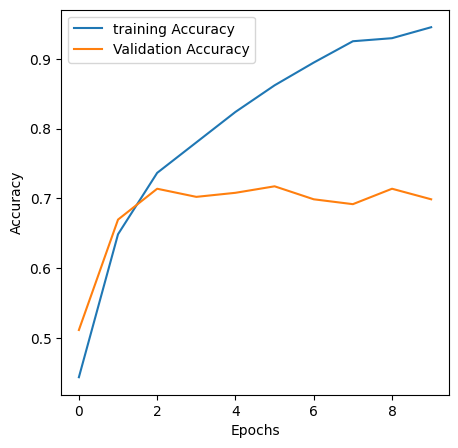

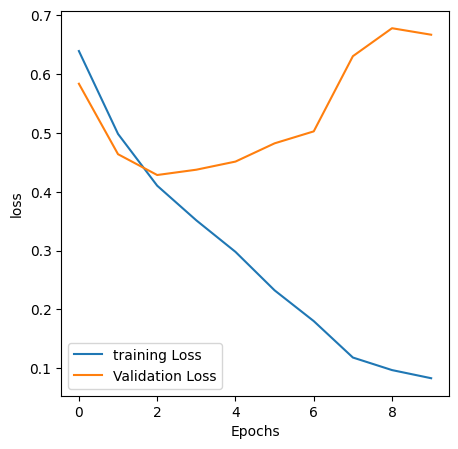

In [63]:
plt.figure(figsize=(5,5))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(TCHistory.history['accuracy'] , label='training Accuracy')
plt.plot(TCHistory.history['val_accuracy'] , label='Validation Accuracy')
plt.legend()
plt.figure(figsize=(5,5))
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.plot(TCHistory.history['loss'], label='training Loss')
plt.plot(TCHistory.history['val_loss'], label='Validation Loss')
plt.legend()

We then repeated the process of generating and evaluating models with different filter sizes, number of layers, and with dropout and scheduled learning rate incorporated. We compared the performance of the new models with the previous ones and selected the best performing model based on validation accuracy.
After training and evaluation, we plotted the training and validation loss and accuracy curves for each model using matplotlib, and selected the best performing model based on the validation accuracy.


Total number of models :  9
Model Number 1 with :
Conv2D layer with kernel size (3, 3) and filters 8 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 16 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 32 
Dropout layer
MaxPooling2D layer
Dense layer with 16 units
Dense layer with 3 units
Epoch 1/10
108/108 [==============================] - 21s 185ms/step - loss: 0.6642 - accuracy: 0.3526 - val_loss: 0.6410 - val_accuracy: 0.4221 - lr: 0.0010
Epoch 2/10
108/108 [==============================] - 21s 189ms/step - loss: 0.6001 - accuracy: 0.5371 - val_loss: 0.5862 - val_accuracy: 0.5442 - lr: 0.0010
Epoch 3/10
108/108 [==============================] - 21s 192ms/step - loss: 0.5397 - accuracy: 0.5674 - val_loss: 0.5648 - val_accuracy: 0.5314 - lr: 0.0010
Epoch 4/10
108/108 [==============================] - 20s 181ms/step - loss: 0.5083 - accuracy: 0.5857 - val_loss: 0.5418 - val_accuracy: 0.5849 - lr: 0.0010
Epoch 5/10

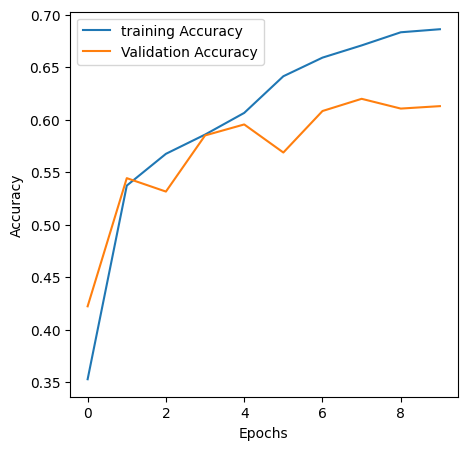

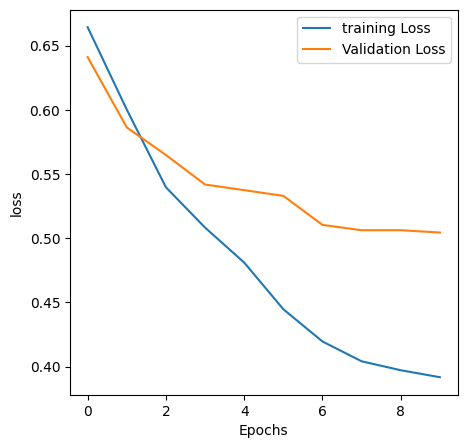

27/27 [==============================] - 4s 143ms/step - loss: 0.5044 - accuracy: 0.6128
Validation accuracy: 0.6127907037734985
Finished training model 1 out of 9 models.

Model Number 2 with :
Conv2D layer with kernel size (3, 3) and filters 8 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 32 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 64 
Dropout layer
MaxPooling2D layer
Dense layer with 16 units
Dense layer with 3 units
Epoch 1/10
108/108 [==============================] - 21s 189ms/step - loss: 0.6545 - accuracy: 0.4175 - val_loss: 0.6063 - val_accuracy: 0.5151 - lr: 0.0010
Epoch 2/10
108/108 [==============================] - 19s 176ms/step - loss: 0.5770 - accuracy: 0.5257 - val_loss: 0.5829 - val_accuracy: 0.5453 - lr: 0.0010
Epoch 3/10
108/108 [==============================] - 19s 170ms/step - loss: 0.5352 - accuracy: 0.5534 - val_loss: 0.5421 - val_accuracy: 0.5477 - lr: 0.0010
Epoch 4/10
108/108 [===

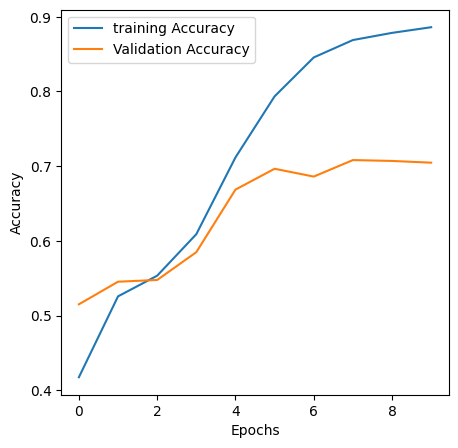

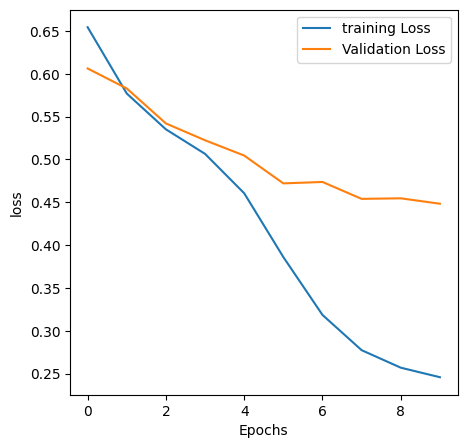

27/27 [==============================] - 4s 139ms/step - loss: 0.4483 - accuracy: 0.7047
Validation accuracy: 0.7046511769294739
Finished training model 2 out of 9 models.

Model Number 3 with :
Conv2D layer with kernel size (3, 3) and filters 8 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 64 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 128 
Dropout layer
MaxPooling2D layer
Dense layer with 16 units
Dense layer with 3 units
Epoch 1/10
108/108 [==============================] - 20s 179ms/step - loss: 0.6336 - accuracy: 0.4670 - val_loss: 0.5856 - val_accuracy: 0.5872 - lr: 0.0010
Epoch 2/10
108/108 [==============================] - 19s 172ms/step - loss: 0.5015 - accuracy: 0.6442 - val_loss: 0.5224 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 3/10
108/108 [==============================] - 19s 171ms/step - loss: 0.4306 - accuracy: 0.7154 - val_loss: 0.4668 - val_accuracy: 0.7151 - lr: 0.0010
Epoch 4/10
108/108 [==

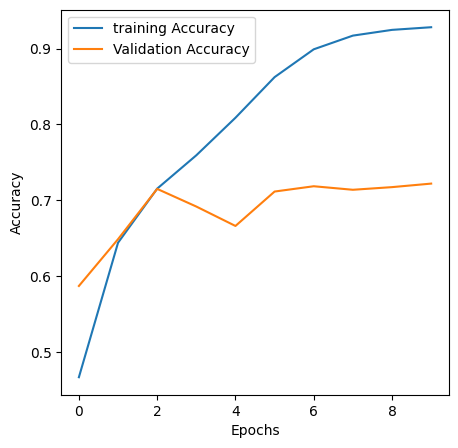

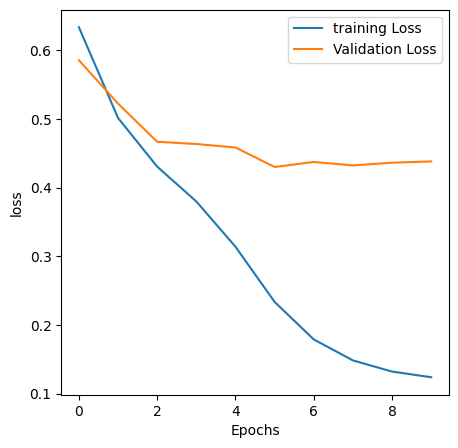

27/27 [==============================] - 4s 142ms/step - loss: 0.4382 - accuracy: 0.7221
Validation accuracy: 0.7220930457115173
Finished training model 3 out of 9 models.

Model Number 4 with :
Conv2D layer with kernel size (3, 3) and filters 8 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 16 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 32 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 64 
Dropout layer
MaxPooling2D layer
Dense layer with 16 units
Dense layer with 3 units
Epoch 1/10
108/108 [==============================] - 20s 178ms/step - loss: 0.6506 - accuracy: 0.3532 - val_loss: 0.6453 - val_accuracy: 0.3453 - lr: 0.0010
Epoch 2/10
108/108 [==============================] - 19s 176ms/step - loss: 0.6057 - accuracy: 0.5112 - val_loss: 0.6136 - val_accuracy: 0.5721 - lr: 0.0010
Epoch 3/10
108/108 [==============================] - 19s 174ms/step - loss: 0.5604 - accuracy:

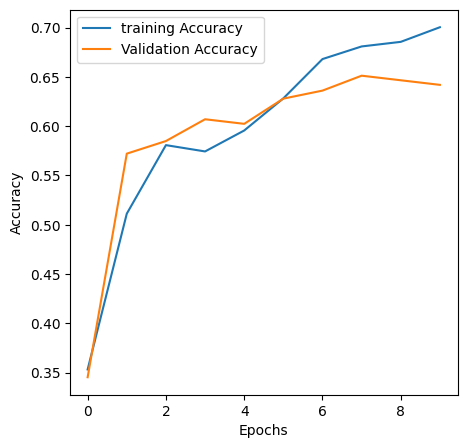

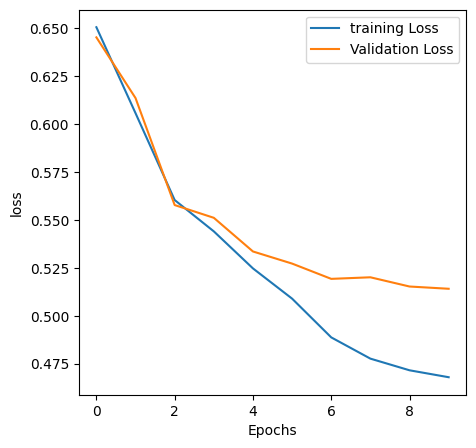

27/27 [==============================] - 4s 143ms/step - loss: 0.5141 - accuracy: 0.6419
Validation accuracy: 0.6418604850769043
Finished training model 4 out of 9 models.

Model Number 5 with :
Conv2D layer with kernel size (3, 3) and filters 8 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 32 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 64 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 128 
Dropout layer
MaxPooling2D layer
Dense layer with 16 units
Dense layer with 3 units
Epoch 1/10
108/108 [==============================] - 19s 174ms/step - loss: 0.6375 - accuracy: 0.4417 - val_loss: 0.6041 - val_accuracy: 0.5512 - lr: 0.0010
Epoch 2/10
108/108 [==============================] - 19s 177ms/step - loss: 0.5337 - accuracy: 0.5927 - val_loss: 0.5291 - val_accuracy: 0.6581 - lr: 0.0010
Epoch 3/10
108/108 [==============================] - 19s 173ms/step - loss: 0.4581 - accuracy

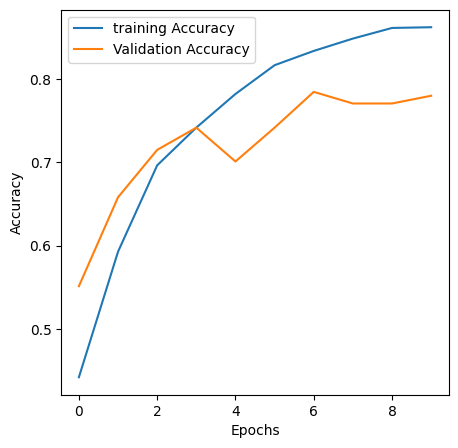

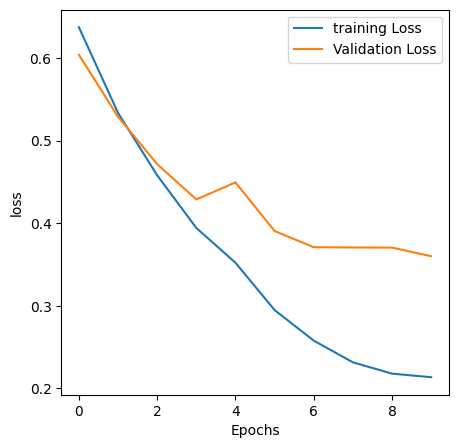

27/27 [==============================] - 4s 141ms/step - loss: 0.3600 - accuracy: 0.7802
Validation accuracy: 0.7802325487136841
Finished training model 5 out of 9 models.

Model Number 6 with :
Conv2D layer with kernel size (3, 3) and filters 8 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 64 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 128 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 256 
Dropout layer
MaxPooling2D layer
Dense layer with 16 units
Dense layer with 3 units
Epoch 1/10
108/108 [==============================] - 20s 175ms/step - loss: 0.6515 - accuracy: 0.3779 - val_loss: 0.6346 - val_accuracy: 0.4872 - lr: 0.0010
Epoch 2/10
108/108 [==============================] - 19s 179ms/step - loss: 0.5502 - accuracy: 0.5915 - val_loss: 0.5097 - val_accuracy: 0.6733 - lr: 0.0010
Epoch 3/10
108/108 [==============================] - 19s 172ms/step - loss: 0.4378 - accurac

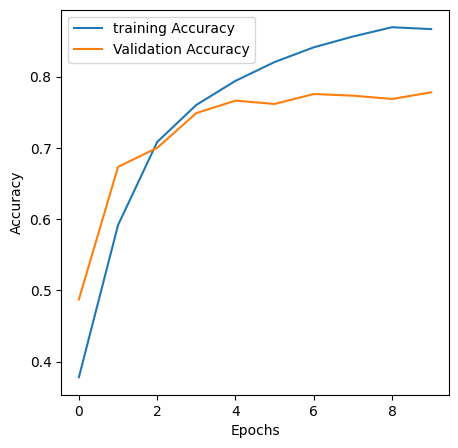

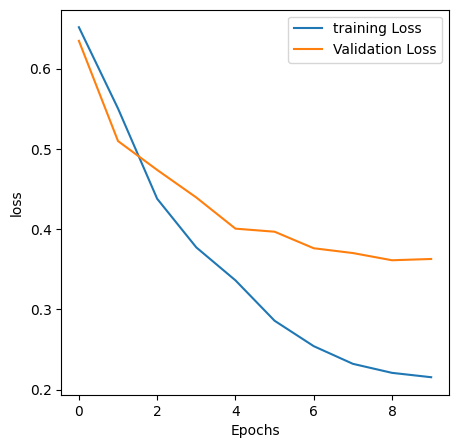

27/27 [==============================] - 4s 144ms/step - loss: 0.3628 - accuracy: 0.7779
Validation accuracy: 0.7779069542884827
Finished training model 6 out of 9 models.

Model Number 7 with :
Conv2D layer with kernel size (3, 3) and filters 8 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 16 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 32 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 64 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 128 
Dropout layer
MaxPooling2D layer
Dense layer with 16 units
Dense layer with 3 units
Epoch 1/10
108/108 [==============================] - 19s 175ms/step - loss: 0.6341 - accuracy: 0.3809 - val_loss: 0.6339 - val_accuracy: 0.4174 - lr: 0.0010
Epoch 2/10
108/108 [==============================] - 19s 177ms/step - loss: 0.5785 - accuracy: 0.5563 - val_loss: 0.6050 - val_accuracy: 0.5744 - lr: 0.0010
Epoch 3/

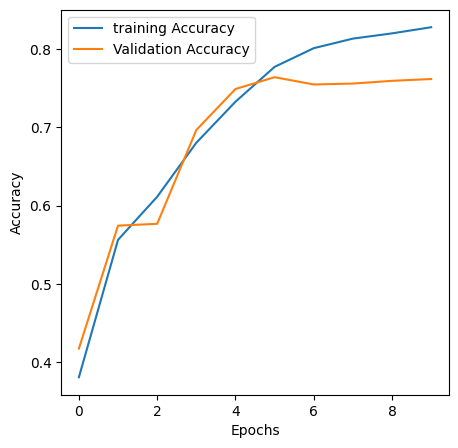

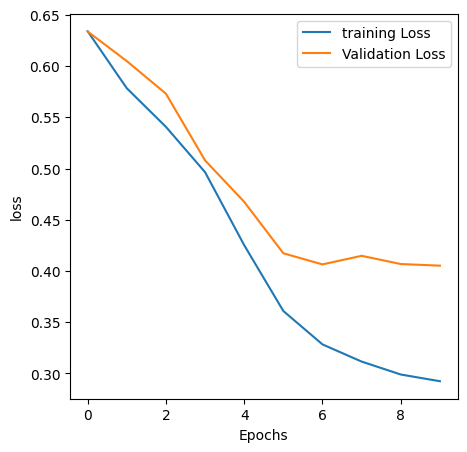

27/27 [==============================] - 4s 141ms/step - loss: 0.4053 - accuracy: 0.7616
Validation accuracy: 0.7616279125213623
Finished training model 7 out of 9 models.

Model Number 8 with :
Conv2D layer with kernel size (3, 3) and filters 8 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 32 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 64 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 128 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 256 
Dropout layer
MaxPooling2D layer
Dense layer with 16 units
Dense layer with 3 units
Epoch 1/10
108/108 [==============================] - 20s 176ms/step - loss: 0.6450 - accuracy: 0.3666 - val_loss: 0.6258 - val_accuracy: 0.4186 - lr: 0.0010
Epoch 2/10
108/108 [==============================] - 19s 175ms/step - loss: 0.5858 - accuracy: 0.4568 - val_loss: 0.5805 - val_accuracy: 0.4360 - lr: 0.0010
Epoch 3

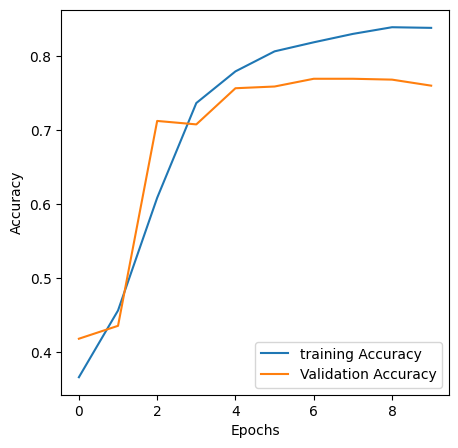

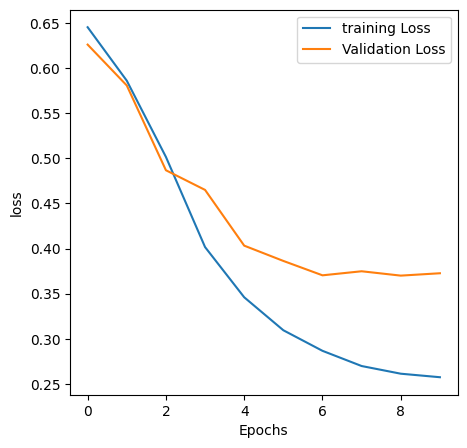

27/27 [==============================] - 4s 141ms/step - loss: 0.3726 - accuracy: 0.7605
Validation accuracy: 0.760465145111084
Finished training model 8 out of 9 models.

Model Number 9 with :
Conv2D layer with kernel size (3, 3) and filters 8 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 64 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 128 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 256 
Dropout layer
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 512 
Dropout layer
MaxPooling2D layer
Dense layer with 16 units
Dense layer with 3 units
Epoch 1/10
108/108 [==============================] - 20s 178ms/step - loss: 0.6363 - accuracy: 0.4286 - val_loss: 0.6275 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 2/10
108/108 [==============================] - 19s 178ms/step - loss: 0.5174 - accuracy: 0.6456 - val_loss: 0.5001 - val_accuracy: 0.6628 - lr: 0.0010
Epoch 3

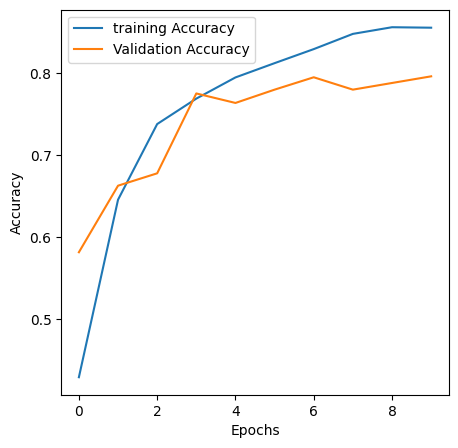

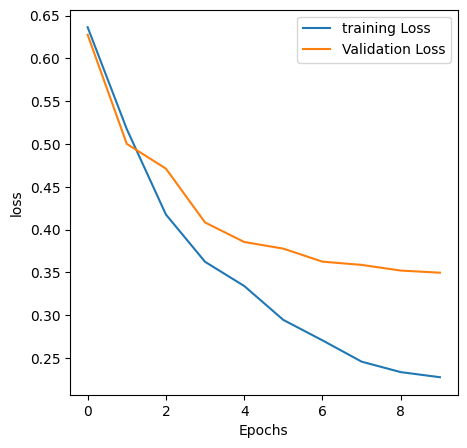

27/27 [==============================] - 4s 141ms/step - loss: 0.3497 - accuracy: 0.7965
Validation accuracy: 0.7965116500854492
Finished training model 9 out of 9 models.


The best validation accuracy is 0.7965
The model summary of the best model is:
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_181 (Conv2D)         (None, 222, 222, 8)       224       
                                                                 
 dropout_137 (Dropout)       (None, 222, 222, 8)       0         
                                                                 
 max_pooling2d_179 (MaxPooli  (None, 111, 111, 8)      0         
 ng2D)                                                           
                                                                 
 conv2d_182 (Conv2D)         (None, 109, 109, 64)      4672      
                                                                

In [71]:
# define the different filter sizes and number of layers to try
filter_sizes = [16, 32, 64]
num_layers = [3, 4, 5]
# define the scheduler function
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.5
# count the total number of models
total_models = len(filter_sizes) * len(num_layers)
print("Total number of models : ",total_models)
# initialize variables to track the best model and its evaluation
best_model = None
best_val_acc = 0
best_model_number = 0
count = 0
# create a list to store all histories
histories = []

# loop over the different filter sizes and number of layers
for n_layers in num_layers:
    for filter_size in filter_sizes:
        count += 1;
        # create the model with the current filter size and number of layers
        model = Sequential()
        model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(224, 224, 3)))
        model.add(Dropout(0.2))
        model.add(MaxPooling2D((2, 2)))
        for i in range(n_layers - 1):
            model.add(Conv2D(filter_size, (3, 3), activation='relu'))
            model.add(Dropout(0.2))
            model.add(MaxPooling2D((2, 2)))
            filter_size *= 2
        model.add(Flatten())
        model.add(Dense(16, activation='relu'))
        model.add(Dense(3, activation='sigmoid'))
        print(f"Model Number {count} with :")
        # print model summary
        for layer in model.layers:
            if isinstance(layer, Conv2D):
                print(f"Conv2D layer with kernel size {layer.kernel_size} and filters {layer.filters} ")
            elif isinstance(layer, MaxPooling2D):
                print("MaxPooling2D layer")
            elif isinstance(layer, Dropout):
                print("Dropout layer")
            elif isinstance(layer, Dense):
                print(f"Dense layer with {layer.units} units")

        # create the scheduler callback
        lr_scheduler = LearningRateScheduler(scheduler)

        # compile the model with the scheduler callback
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # train the model with the scheduler callback
        history = model.fit(train_generator_threecommon, epochs=10,  validation_data=valid_generator_threecommon, callbacks=[lr_scheduler])

        # append the history to the list
        histories.append(history.history)

        # plot training and validation loss and accuracy
        plt.figure(figsize=(5,5))
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.plot(history.history['accuracy'] , label='training Accuracy')
        plt.plot(history.history['val_accuracy'] , label='Validation Accuracy')
        plt.legend()
        plt.show()

        plt.figure(figsize=(5,5))
        plt.xlabel("Epochs")
        plt.ylabel("loss")
        plt.plot(history.history['loss'], label='training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.show()

        # check if the current model is the best one so far
        if history.history['val_accuracy'][-1] > best_val_acc:
            best_val_acc = history.history['val_accuracy'][-1]
            best_model = model
            best_model_number = count
        evaluation = model.evaluate(valid_generator_threecommon)
        print(f"Validation accuracy: {evaluation[1]}")
        # print progress
        print(f"Finished training model {len(histories)} out of {total_models} models.\n")


# print the best evaluation and the model summary of it
print(f"\nThe best validation accuracy is {best_val_acc:.4f}")
print("The model summary of the best model is:")
best_model.summary()
for layer in best_model.layers:
    if isinstance(layer, Conv2D):
          print(f"Conv2D layer with kernel size {layer.kernel_size} and filters {layer.filters} ")
    elif isinstance(layer, MaxPooling2D):
                print("MaxPooling2D layer")
    elif isinstance(layer, Dense):
                print(f"Dense layer with {layer.units} units")

So by changing parameters and run 9 models, we found out that the optimal model has below configuration:
Conv2D layer with kernel size (3, 3) and filters 8
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 64
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 128
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 256
MaxPooling2D layer
Conv2D layer with kernel size (3, 3) and filters 512
MaxPooling2D layer
Dense layer with 16 units
Dense layer with 3 units

now we create a model.

In [72]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.5

model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(3, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


running model by passing train and valid data to it. we save all metrics to FinalHistory.

In [73]:
FinalHistory = model.fit(train_generator_threecommon, epochs=10,  validation_data=valid_generator_threecommon, callbacks=[lr_scheduler])

Epoch 1/10
108/108 [==============================] - 21s 191ms/step - loss: 0.6025 - accuracy: 0.4987 - val_loss: 0.5810 - val_accuracy: 0.5965 - lr: 0.0010
Epoch 2/10
108/108 [==============================] - 19s 174ms/step - loss: 0.4927 - accuracy: 0.6686 - val_loss: 0.4834 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/10
108/108 [==============================] - 19s 172ms/step - loss: 0.3954 - accuracy: 0.7541 - val_loss: 0.4100 - val_accuracy: 0.7663 - lr: 0.0010
Epoch 4/10
108/108 [==============================] - 19s 177ms/step - loss: 0.3658 - accuracy: 0.7681 - val_loss: 0.4311 - val_accuracy: 0.7663 - lr: 0.0010
Epoch 5/10
108/108 [==============================] - 19s 174ms/step - loss: 0.3266 - accuracy: 0.7990 - val_loss: 0.3967 - val_accuracy: 0.7477 - lr: 0.0010
Epoch 6/10
108/108 [==============================] - 19s 175ms/step - loss: 0.2939 - accuracy: 0.8193 - val_loss: 0.3581 - val_accuracy: 0.7895 - lr: 5.0000e-04
Epoch 7/10
108/108 [============================

Plotting the history to see the curve of accuracy and loss for both training and validating the model.

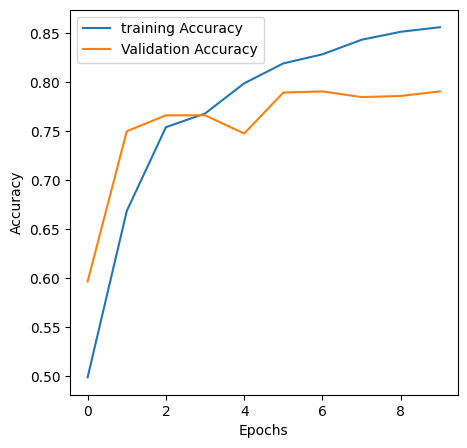

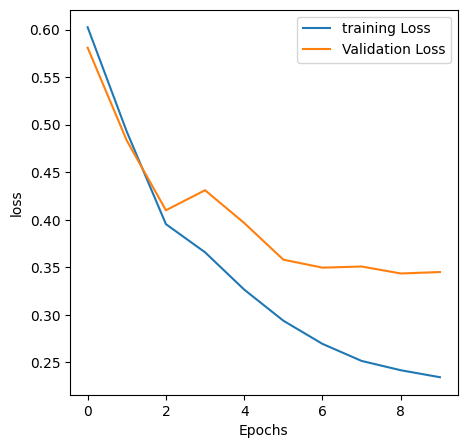

In [74]:
plt.figure(figsize=(5,5))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(FinalHistory.history['accuracy'] , label='training Accuracy')
plt.plot(FinalHistory.history['val_accuracy'] , label='Validation Accuracy')
plt.legend()
plt.figure(figsize=(5,5))
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.plot(FinalHistory.history['loss'], label='training Loss')
plt.plot(FinalHistory.history['val_loss'], label='Validation Loss')
plt.legend()

END